In [2]:
from sql_equivalence import SQLEquivalenceAnalyzer

analyzer = SQLEquivalenceAnalyzer(dialect='sqlite')

sql1 = "SELECT * FROM users WHERE age > 18"
sql2 = "SELECT * FROM users WHERE age >= 19"

sql1 = """SELECT D.a AS f1, D.k AS grp 
FROM (
    SELECT A.a, A.k 
    FROM tbl AS A 
    LEFT JOIN tbl2 AS B ON A.k = B.k
) AS D
GROUP BY D.k """

sql2 = """SELECT D.a AS f1, D.k AS grp 
FROM (
    SELECT A.a, A.k 
    FROM tbl AS A 
    LEFT JOIN tbl2 AS B ON B.k = A.k
) AS D
GROUP BY D.k """


result = analyzer.analyze(sql1, sql2)
print(f"Equivalent: {result.is_equivalent}")

Equivalent: False


In [3]:
methods = ['algebraic']
parsed1 = analyzer.parser.parse(sql1)
parsed2 = analyzer.parser.parse(sql2)
expr1 = parsed1.to_algebraic()
expr2 = parsed2.to_algebraic()

In [4]:
from sql_equivalence.equivalence.base import  EquivalenceChecker, EquivalenceResult, EquivalenceType

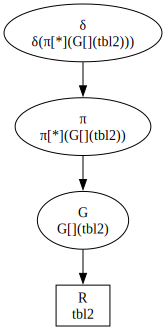

In [5]:
expr1.visualize()

In [ ]:
expr2.visualize()

In [ ]:
from sql_equivalence.representations.algebraic.operators import (
    AlgebraicOperator, ProjectOperator, SelectOperator, JoinOperator,
    UnionOperator, IntersectOperator, ExceptOperator, AggregateOperator,
    RelationOperator, OperatorType
)

enable_normalization = True
enable_proof_generation = True


def set_make_hashable(x):
    def make_hashable(item):
        if isinstance(item, dict):
            return tuple(sorted(item.items()))
        return item
    return set( [make_hashable(item) for item in x] )
    
def _operators_equal(op1: AlgebraicOperator, 
                    op2: AlgebraicOperator) -> bool:
    """Check if two operators are equal."""
    if type(op1) != type(op2):
        return False
    
    if op1.operator_type != op2.operator_type:
        return False
    
    # Check operator-specific attributes
    if isinstance(op1, ProjectOperator):
        if set_make_hashable(op1.columns) != set_make_hashable(op2.columns):
            return False
    
    elif isinstance(op1, SelectOperator):
        if op1.condition != op2.condition:
            return False
    
    elif isinstance(op1, JoinOperator):
        if op1.join_type != op2.join_type:
            return False
        if op1.condition != op2.condition:
            return False
    
    elif isinstance(op1, RelationOperator):
        if op1.table_name != op2.table_name:
            return False
    
    # Check children
    if len(op1.children) != len(op2.children):
        return False
    
    for c1, c2 in zip(op1.children, op2.children):
        if not _operators_equal(c1, c2):
            return False
    
    return True
    
def _operator_to_string(op: AlgebraicOperator) -> str:
    """Convert operator to a stable string representation for hashing."""
    if not op:
        return ""
    
    # Create a string that uniquely identifies the operator
    parts = [
        op.operator_type.value,
        str(type(op).__name__)
    ]
    
    # Add operator-specific attributes
    if isinstance(op, SelectOperator):
        condition_str = json.dumps(
            op.condition, sort_keys=True) if isinstance(op.condition, dict) else str(op.condition)
        parts.append(condition_str)
        
        ## if isinstance(op.condition, dict):
        ##     parts.append(json.dumps(op.condition, sort_keys=True))
        ## else:
        ##     parts.append(str(op.condition))
    elif isinstance(op, ProjectOperator):
        parts.append(str(sorted(str(c) for c in op.columns)))
    elif isinstance(op, JoinOperator):
        parts.append(op.join_type)
        if isinstance(op.condition, dict):
            parts.append(json.dumps(op.condition, sort_keys=True))
        else:
            parts.append(str(op.condition))
    elif isinstance(op, RelationOperator):
        parts.append(op.table_name)
    elif isinstance(op, AggregateOperator):
        parts.append(str(sorted(str(a) for a in op.aggregations)))
        parts.append(str(sorted(op.group_by)))
    
    # Add children hashes
    child_hashes = []
    for child in op.children:
        child_hashes.append(_operator_to_string(child))
    parts.append(str(child_hashes))
    
    return "|".join(parts)


def get_operator_hash(op):
    return _operator_to_string(op)


visited = set()
queue = [(expr1.root_operator.clone(), [])]
visited.add(get_operator_hash(expr1.root_operator))
iterations = 0
max_transformations = 100
result = EquivalenceResult(
            is_equivalent=False,
            equivalence_type=EquivalenceType.NOT_EQUIVALENT,
            confidence=0.0)

while queue and iterations < max_transformations:
    current_op, proof_steps = queue.pop(0)
    iterations += 1
    
    # Check if we've reached the target
    if _operators_equal(current_op, expr2.root_operator):
        if enable_proof_generation:
            for step in proof_steps:
                result.add_proof_step(step)
        print(True)
    

                    